In [1]:
import numpy as np
import cv2
import sklearn
import scipy
import imageio
import math
from skimage.color import rgb2gray
import matplotlib.pyplot as plt
from scipy.optimize import least_squares, minimize_scalar, root_scalar
import glob

In [2]:
def extract_num(fp):
    return int(fp.split('.')[0].split(' ')[1])

In [3]:
# find the offsets for the horizontal images
def get_phase_correlations(images):
    offsets = []
    for i in range(len(images)-1):
        d = cv2.phaseCorrelate(images[i], images[i+1])
        offsets.append(d)
    return offsets

In [4]:
def combine_images(image1, image2, offset_x, offset_y):
    offset_x = -int(offset_x)
    offset_y = int(offset_y)
    if offset_x < 0:
        merge_width = max(image2.shape[1], image1.shape[1]-offset_x)
        warp_offset_x = 0
        ref_offset_x = offset_x
    else:
        merge_width = max(image2.shape[1] + offset_x, image1.shape[1])
        warp_offset_x = offset_x
        ref_offset_x = 0
    if offset_y < 0:
        merge_height = max(image2.shape[0], image1.shape[0]-offset_y)
        warp_offset_y = 0
        ref_offset_y = offset_y
    else:
        merge_height = max(image2.shape[0] + offset_y, image1.shape[0])
        warp_offset_y = offset_y
        ref_offset_y = 0
    
    combined_image = np.zeros((merge_height,merge_width,3)).astype(np.uint8)
    for y in range(image2.shape[0]):
        for x in range(image2.shape[1]):
            combined_image[y+warp_offset_y,x+warp_offset_x] = image2[y,x]
    
    for y in range(image1.shape[0]):
        for x in range(image1.shape[1]):
            if np.all((combined_image[y-ref_offset_y,x-ref_offset_x] == 0)):
                combined_image[y-ref_offset_y, x-ref_offset_x] = image1[y,x]
    return combined_image

In [5]:
# calculate f: 2pi - 2 * sum(atan(d_i /f)) = 0
def compute_f(widths):
    widths = np.asarray(widths)
    def cost(f):
        goal = 2*np.pi
        val = 2*np.arctan(widths / f).sum()
        return val - goal

    def costprime(f):
        # derivative of cost
        return (widths / (widths ** 2 + f ** 2)).sum()
    
    res = root_scalar(cost, bracket=(250, 750), fprime=costprime)
    return(res.root)

In [6]:
def horizontalAngle(horizontal_shifts, focal_length):
    thetas = [None * len(horizontal_shifts)]
    thetas[0] = 0 
    for i in range(1, len(horizontal_shifts)):
        thetas[i] = thetas[i-1] + 2*np.arctan(thetas[i] / (2*f))
    return thetas

In [7]:
def verticalAngle(vertical_shifts, focal_length):
    gammas = [None * len(vertical_shifts)]
    gammas[0] = 0 
    for i in range(1, len(horizontal_shifts)):
        thetas[i] = thetas[i-1] + 2*np.arctan(thetas[i] / (2*f))
    return thetas

In [8]:
# read in the images
row0_files = sorted(glob.glob("test_data_6/0*"), key=extract_num)
row1_files = sorted(glob.glob("test_data_6/1*"), key=extract_num)

# row0 is horizontal, and row1 is above the horizontal 
row0, row1 = [cv2.imread(i) for i in row0_files], [cv2.imread(i) for i in row1_files]

image_matrix = [row1, row0]

In [9]:
# Compute Phase Correlations
phase_corr_rows = [[[0,0] for y in x] for x in image_matrix]
for r_i in range(len(image_matrix)):
    for c_i in range(len(image_matrix[r_i]) - 1):
        curr_corr = cv2.phaseCorrelate(rgb2gray(image_matrix[r_i][c_i]), rgb2gray(image_matrix[r_i][c_i+1]))
        phase_corr_rows[r_i][c_i+1] = [curr_corr[0][0], curr_corr[0][1]]

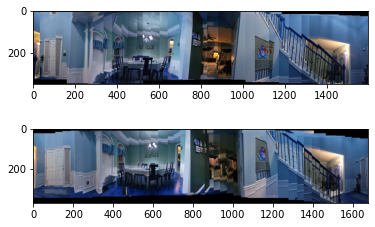

In [10]:
# Simple Combine Images
simple_combine_rows = [] 
for r_i in range(len(image_matrix)):
    combined_image = None
    offset_x = 0
    offset_y = 0
    for c_i in range(len(image_matrix[r_i]) - 1):
        if combined_image is None:
            combined_image = image_matrix[r_i][c_i]
        else:
            offset_x += phase_corr_rows[r_i][c_i][0]
            offset_y += phase_corr_rows[r_i][c_i][1] 
            combined_image = combine_images(combined_image, image_matrix[r_i][c_i+1], offset_x, offset_y)
    simple_combine_rows.append(combined_image)

fig,axes = plt.subplots(len(image_matrix), 1)
for im_i in range(len(simple_combine_rows)):
    axes[im_i].imshow(simple_combine_rows[im_i])
    
plt.show()

In [11]:
# Focal Lengths
focal_lengths = []
all_widths = [[-y[0] for y in x if y is not None] for x in phase_corr_rows]
for row in all_widths:
    focal_lengths.append(compute_f(row))
focal_len = sum(focal_lengths)/len(focal_lengths)

In [12]:
# Compute Horizontal Angles (theta, phi)
image_angles = [[[0,0] for y in x] for x in image_matrix]
for r_i in range(len(image_matrix)):
    for c_i in range(len(image_matrix[r_i]) - 1):
        image_angles[r_i][c_i+1][0] = image_angles[r_i][c_i][0] + 2*np.arctan(-phase_corr_rows[r_i][c_i+1][0] / (2*focal_len))


In [111]:
def compute_transformation_matrix(f, theta, phi): 
    r0 = [
        [1,  0,           0           ],
        [0,  np.cos(phi), -np.sin(phi)],
        [0,  np.sin(phi), np.cos(phi) ]
    ]
    r1 = [
        [np.cos(theta),  0, np.sin(theta)], 
        [      0,        1,      0       ], 
        [-np.sin(theta), 0, np.cos(theta)]
    ]
    r = np.matmul(np.asarray(r0), np.asarray(r1))
    v = [[f, 0, 0],[0,f,0],[0,0,1]]
    
    tran_mat = np.matmul(v, r) 
#     tran_mat = np.linalg.inv(tran_mat)
    return tran_mat

In [19]:
img_trans_mat = [[None for y in x] for x in image_matrix]
for r_i in range(len(image_matrix)):
    for c_i in range(len(image_matrix[r_i])):
        img_trans_mat[r_i][c_i] = compute_transformation_matrix(focal_len, image_angles[r_i][c_i][0],image_angles[r_i][c_i][1])
        print(img_trans_mat[r_i][c_i] )
        

[[0.00219402 0.         0.        ]
 [0.         0.00219402 0.        ]
 [0.         0.         1.        ]]
[[ 2.18810818e-03  0.00000000e+00 -7.33839666e-02]
 [ 0.00000000e+00  2.19402379e-03  0.00000000e+00]
 [ 1.61006169e-04  0.00000000e+00  9.97303762e-01]]
[[ 2.13245684e-03  0.00000000e+00 -2.35233871e-01]
 [ 0.00000000e+00  2.19402379e-03  0.00000000e+00]
 [ 5.16108709e-04  0.00000000e+00  9.71938797e-01]]
[[ 2.13203634e-03  0.00000000e+00 -2.36024354e-01]
 [ 0.00000000e+00  2.19402379e-03  0.00000000e+00]
 [ 5.17843048e-04  0.00000000e+00  9.71747140e-01]]
[[ 2.05880817e-03  0.00000000e+00 -3.45629824e-01]
 [ 0.00000000e+00  2.19402379e-03  0.00000000e+00]
 [ 7.58320058e-04  0.00000000e+00  9.38370942e-01]]
[[ 0.00196688  0.         -0.44310228]
 [ 0.          0.00219402  0.        ]
 [ 0.00097218  0.          0.89647106]]
[[ 0.001844    0.         -0.54186252]
 [ 0.          0.00219402  0.        ]
 [ 0.00118886  0.          0.84046714]]
[[ 0.00177966  0.         -0.5848526 ]


In [18]:
transformed_images = {}
for r_i in range(len(image_matrix)-1):
    for c_i in range(len(image_matrix[r_i])):
        curr = image_matrix[r_i][c_i]
        for pr_i in range(len(curr)):
            for cr_i in range(len(curr[pr_i])):
                out = np.matmul(img_trans_mat[r_i][c_i], np.asarray([pr_i,cr_i,0]))
                # IDK WHERE TO GO FROM HERE
"""
It seems like the transformation matrices are outputting transformed matrices that
are not correct. They range in the 0.0-1.0 values for x,y,z. Help
"""       

KeyboardInterrupt: 

In [30]:
# create vertical subimage
# test with column test data
col_paths = glob.glob("./column/*")
col_paths.sort()
col =[cv2.imread(i) for i in col_paths]

In [32]:
# compute the vertical offsets
def compute_col_offsets(col):
    offsets = [(0, 0)]
    for i in range(1, len(col)):
        offset = cv2.phaseCorrelate(rgb2gray(col[i-1]), rgb2gray(col[i]))[0]
        offsets.append(offset)
    offsets = np.array(offsets)
    return offsets

print(compute_col_offsets(col0))

[[ 0.          0.        ]
 [26.64327949 32.80522368]]


In [34]:
def compute_col_angles(col, focal_length, horizontal_index = 0):
    # horizontal_index - index of horizontal image in column
    offsets = compute_col_offsets(col)
    angles = np.zeros((len(col), 2)) # x-direction, y-direction
    for i in range(1, len(col)):
        angles[i][0] = angles[i-1][0] + 2 * np.arctan(offsets[i][0] / (2 * focal_length))
        angles[i][1] = angles[i-1][0] + 2 * np.arctan(offsets[i][1] / (2 * focal_length))
    angles -= angles[horizontal_index]
    return angles
print(compute_col_angles(col0, focal_len))

[[0.         0.        ]
 [0.05843935 0.07194439]]


In [131]:
def haversine_dist(theta1, phi1,theta2, phi2):
    def haversine(th):
        return (1 - np.cos(th)) / 2
    h = haversine(phi2 - phi1) + np.cos(phi1) * np.cos(phi2) * haversine(theta2 - theta1)
    d = 2 * np.arcsin(np.sqrt(h))
    return d


def create_vertical_subimage(col, focal_length, horizontal_index = 0):
    angles = compute_col_angles(col,focal_length, horizontal_index) * np.asarray((1, -1))
    
    result = np.zeros((320 * len(col), 480, 3), dtype=np.uint8)
    origin_y = result.shape[0] / 2
    origin_x = result.shape[1] / 2
    
    for y_coord in range(result.shape[0]):
        for x_coord in range(result.shape[1]):
            beta = (y_coord - origin_y) / focal_length
            alpha = (x_coord - origin_x) / focal_length
            
            # find the closest image
            best_idx, max_dist = None, float('inf')
            for i in range(len(col)):
                theta, phi = angles[i]
#                 dist = (theta - alpha) ** 2 + (phi - beta) ** 2
                dist = haversine_dist(theta, phi, alpha, beta)
                if dist < max_dist:
                    best_idx = i
                    max_dist = dist
            projection = compute_transformation_matrix(focal_length, angles[best_idx][0], angles[best_idx][1])
#             p = np.array((y_coord - origin_y, x_coord - origin_x, 1)).reshape(-1, 1)
            # spherical to Cartesian
            p = np.array((alpha, beta, 1)).reshape(-1,1)
            q = projection @ p 
#             print(q)
            x, y, _ = q / q[-1]
#             print(x, y)
            if np.isnan(x) or np.isnan(y):
                continue
            x += col[best_idx].shape[1] / 2
            y += col[best_idx].shape[0] / 2
            x = int(x)
            y = int(y)
            if 0 <= x < col[best_idx].shape[1] and 0 <= y < col[best_idx].shape[0]:
                result[y_coord][x_coord] = col[best_idx][y][x]

    return result
            

In [ ]:
subimage = create_vertical_subimage(col0, focal_len)
# print(subimage[0])

In [ ]:
plt.imshow(subimage)

dtype('uint8')